# KNN - Heart disease classification
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before applying KNN
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### Number of neighbors
The most important feature of the KNN algorithm is the `n_neighbors` number of neighbors to look at. A too high n will cause overfitting, while a too low number will underfit the model.

#### Distance metric
The KNN algorithm can choose to use either Manhattan distance or Euclidian distance to calculate how far away the neighbors are. 

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [1]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve, validation_curve

In [2]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `n_neighbors`: odd numbers from 3 to 31.
- `p`: Manhattan distance (1) or euclidian distance (2).

In [3]:
# Define the parameter grid
param_grid = {
    'n_neighbors': np.arange(3, 32, 2),  
    'p': [1, 2]  
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the six best combinations from the grid search.

In [4]:
# Define model
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the five best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_6 = results.nlargest(6, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_6 = top_6[['param_n_neighbors', 'param_p', 'mean_test_score', 'std_test_score']]

top_6

,param_n_neighbors,param_p,mean_test_score,std_test_score
10,13,1,0.858337,0.041251
8,11,1,0.854813,0.043566
6,9,1,0.854773,0.047334
26,29,1,0.854628,0.042333
28,31,1,0.853835,0.044459
12,15,1,0.853692,0.044453


The six best combinations using F1-score are
- in the range 9-31 for `n_neighbors`.
- all the best are using Manhattan distance.

The combination of hyperparameters with the highest mean F1 score from the grid search uses `n_neighbors=13`. Having a relatively low n as the top performer is a good sign, as it avoids overfitting of the model. This combination also has the lowest standard deviation, showing a stable performance across different folds.

### Evaluating top 6 combinations
We will continue by examining how these six top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [5]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [6]:
# DataFrame with evaluation metric for each of the top 6 models
evaluation_results = pd.DataFrame(columns=['n_neighbors', 'p', 'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_6.iterrows():

    # Dict with params from the row
    params = {
        'n_neighbors': row['param_n_neighbors'],
        'p': row['param_p']
    }

    # Fit the model with params
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], p=params['p'])
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'n_neighbors': params['n_neighbors'],
        'p': params['p'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row


evaluation_results

,n_neighbors,p,Recall,F1-score,Precision,Precision-recall AUC
0,13,1,0.820,0.862,0.908,0.926
1,11,1,0.842,0.875,0.911,0.931
2,9,1,0.842,0.875,0.911,0.932
3,29,1,0.842,0.875,0.911,0.941
4,31,1,0.850,0.879,0.911,0.942
5,15,1,0.835,0.871,0.910,0.923


From these results, we see will further evaluate a model using `n_neighbors=9` and `p=1`. This is due to the following considerations:
- The Recall rate is tied second best, and only insignificantly lower (0.008) than the best. 
- The F1-score rate is tied second best, and only insignificantly lower (0.004) than the best. 
- The F1-score rate is tied best. 
- While performing approximately as well, this combination has significantly lower n than the top performers (9 compared to 29 and 31). By choosing this, we will get a model that is both less computationally expensive and less prone to overfitting, without compromising the results.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for n in the range 1 to 29.

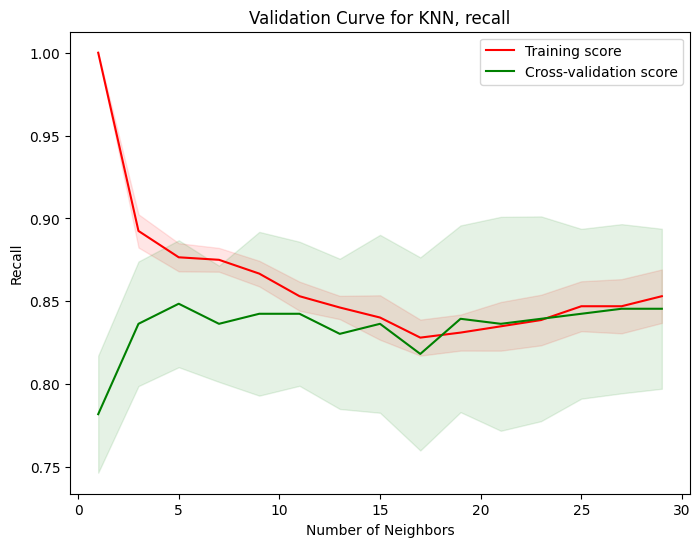

In [7]:
# Define parameter range for validation curve
param_range = np.arange(1, 30, 2)

# Calculate scores for validation curve
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train, param_name="n_neighbors", 
    param_range=param_range,
    cv=5, scoring="recall", n_jobs=-1)

# Calculate mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training score", color="r")
plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title("Validation Curve for KNN, recall")
plt.xlabel("Number of Neighbors")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

The validation curve shows how recall changes as we adjust `n_neighbors`. We see that

- At very low values (close to 1), the recall is extremely high on the training data but much lower on the cross-validation data. This suggests that the model is overfitting, and not generalizing.

- As n_neighbors increases, the recall on the training data drops, indicating that the model is starting to generalize. The recall on the cross-validation data improves and stabilizes, which also suggests that the model's ability to generalize is improving.

- Between about 9 to 15 neighbors, the training and cross-validation scores are closest, indicating a good balance between learning from the training data and generalizing to new data. This aligns with the choice of `n_neighbors=9`.

- Beyond 15, the recall starts to slightly decline or flatten on the cross-validation, which might suggest that further increasing n could cause underfitting.

